plasmids = {strain : [{ NCBI_ID : {plasmid : seq}}, plasmid_matrix]}
class plasmid:
    plasmids_present = {plasmid1: (yes/no), plasmid2: (yes/no), ...}

- ok so first I need to get all of the strains set aside in their own little group.
- then I need to get all of the plasmids present for each strain in their group
- then I need to identify which are present and then set those into the data object
- then use that to identify which strain is present based on construction of a new object given strain assignment.

- something like
```
for contig1:
    top_hit = hit1
    top_hit.score = hit1.score
    top_hit.ID = hit1.ID
    top_hit.length = hit1.length
    top_hit.percentIdent = hit1.percentIdent
    # or some iteration of this.
    # then take and parse out the top hit, or rather
    # look through all hits and then parse the ID given by blast to determine which plasmid it says it is. 
    # then use the score, length, percent ident, etc to assign some score to the hit
    # then use all of the scores to assign probability and then use to determine plasmid assignment
    # then after that, use all of the plasmid assignment values to determine strain identification
    # would likely need a probability matrix for each strain given the plasmids present..........
```

In [1]:
import glob
import csv
import pandas
import pprint
import csv
import re
import json
import os
import tqdm


In [2]:
def read_fasta(file_name):
    sequences = {}
    F = open(file_name)
    for line in F:
        if line[0] == '>':
            defline = line.strip()
            defline = defline.replace('>','')
            terms = defline.split()
            seqname = terms[0]
        else:
            if seqname not in sequences:
                sequences[seqname] = list()
            sequences[seqname].append(line.strip())
    for seqname in sequences:
        seq = ''.join(sequences[seqname])
        sequences[seqname] = seq
    return(sequences)


In [3]:
working_directory = '/Users/mf019/bioinformatics/blastDB/BbPlasmid/plasmid_seqs/fresh_attempt/'
input_fastas = working_directory+'NCBI_sequences/ncbi_dataset/data/'
output_dir = working_directory+'output/'
excel_files =output_dir+'excel/'
output_tsv = output_dir+'tsv/'
output_json = output_dir+'json/'
output_plots = output_dir+'plots/'
output_pickles = output_dir+'the_cannery/'


In [4]:
print('working directory: ', working_directory)
print(os.listdir(path=working_directory))
print('input fastas: ', input_fastas)
print(os.listdir(path=input_fastas))
print('output directory: ', output_dir)
print(os.listdir(path=output_dir))
print('excel_files', excel_files)
print(os.listdir(excel_files))
print('TSV output: ', output_tsv)
print(os.listdir(path=output_tsv))
print('JSON output: ', output_json)
print(os.listdir(path=output_json))
print('Plots output: ', output_plots)
print(os.listdir(path=output_plots))
print('Pickles output: ', output_pickles)
print(os.listdir(path=output_pickles))


working directory:  /Users/mf019/bioinformatics/blastDB/BbPlasmid/plasmid_seqs/fresh_attempt/
['.DS_Store', 'NCBI_sequences', 'acc_to_plasmid.tsv', 'output', 'plasmid_heatmap.png', 'notebooks', 'plasmid_heatmap_clustering.png', 'plasmids.json']
input fastas:  /Users/mf019/bioinformatics/blastDB/BbPlasmid/plasmid_seqs/fresh_attempt/NCBI_sequences/ncbi_dataset/data/
['GCA_030445005.1', 'GCA_019134655.1', 'GCA_002151465.1', 'GCA_024733895.1', '.DS_Store', 'GCA_000166655.2', 'GCA_024733995.1', 'GCA_024662195.1', 'GCA_003367295.1', 'GCA_030439605.1', 'GCA_002151485.1', 'pBSV2_2', 'GCA_000181855.2', 'GCA_019464575.1', 'GCA_000021405.1', 'GCA_030444985.1', 'GCA_000181575.2', 'GCA_024733935.1', 'data_summary.tsv', 'GCA_024662175.1', 'GCA_000444465.1', 'assembly_data_report.jsonl', 'GCA_030439665.1', 'GCA_030439625.1', 'GCA_030440345.1', 'GCA_024662155.1', 'GCA_002442595.2', 'GCA_000181555.2', 'GCA_000181715.2', 'GCA_024733915.1', 'GCA_030445065.1', 'GCA_024790485.1', 'GCA_002151505.1', 'GCA_03

In [5]:
os.chdir(path=working_directory)


In [6]:
genomes = glob.glob('**/*.fna', recursive=True)
print("number of genomes present: ",len(genomes))


number of genomes present:  34


Okay, so actually, the PAli genome was messed up because none of the headers for the plasmids had the strain ID in them. 
a quick sed script fixed it. 

```
cat Bb_all_genomes/ncbi_dataset/data/GCA_002151465.1/GCA_002151465.1_ASM215146v1_genomic.fna | grep ">"
>CP019844.1 Borreliella burgdorferi strain PAli, complete sequence
>CP019851.1 Borreliella burgdorferi plasmid lp17, complete sequence
>CP019845.1 Borreliella burgdorferi plasmid cp26, complete sequence
>CP019846.1 Borreliella burgdorferi plasmid cp32-1, complete sequence
>CP019847.1 Borreliella burgdorferi plasmid cp32-3, complete sequence
>CP019848.1 Borreliella burgdorferi plasmid cp32-4, complete sequence
>CP019849.1 Borreliella burgdorferi plasmid cp32-5, complete sequence
>CP019850.1 Borreliella burgdorferi plasmid cp32-9, complete sequence
>CP019852.1 Borreliella burgdorferi plasmid lp36, complete sequence
>CP019853.1 Borreliella burgdorferi plasmid lp38, complete sequence
>CP019854.1 Borreliella burgdorferi plasmid lp54, complete sequence
>CP019855.1 Borreliella burgdorferi plasmid lp56, complete sequence
```
ok lets fix it with sed
```
cat Bb_all_genomes/ncbi_dataset/data/GCA_002151465.1/GCA_002151465.1_ASM215146v1_genomic.fna|sed 's/Borreliella burgdorferi plasmid/Borreliella burgdorferi strain PAli plasmid/g' | > Bb_all_genomes/ncbi_dataset/data/GCA_002151465.1/GCA_002151465.1_ASM215146v1_genomic.fna.fixed
```
ok so lets check the fixed headers
```
cat Bb_all_genomes/ncbi_dataset/data/GCA_002151465.1/GCA_002151465.1_ASM215146v1_genomic.fna.fixed|grep ">"
>CP019844.1 Borreliella burgdorferi strain PAli, complete sequence
>CP019851.1 Borreliella burgdorferi strain PAli plasmid lp17, complete sequence
>CP019845.1 Borreliella burgdorferi strain PAli plasmid cp26, complete sequence
>CP019846.1 Borreliella burgdorferi strain PAli plasmid cp32-1, complete sequence
>CP019847.1 Borreliella burgdorferi strain PAli plasmid cp32-3, complete sequence
>CP019848.1 Borreliella burgdorferi strain PAli plasmid cp32-4, complete sequence
>CP019849.1 Borreliella burgdorferi strain PAli plasmid cp32-5, complete sequence
>CP019850.1 Borreliella burgdorferi strain PAli plasmid cp32-9, complete sequence
>CP019852.1 Borreliella burgdorferi strain PAli plasmid lp36, complete sequence
>CP019853.1 Borreliella burgdorferi strain PAli plasmid lp38, complete sequence
>CP019854.1 Borreliella burgdorferi strain PAli plasmid lp54, complete sequence
>CP019855.1 Borreliella burgdorferi strain PAli plasmid lp56, complete sequence
```
ok so now just rename the fixed file to the original file
```
mv Bb_all_genomes/ncbi_dataset/data/GCA_002151465.1/GCA_002151465.1_ASM215146v1_genomic.fna.fixed Bb_all_genomes/ncbi_dataset/data/GCA_002151465.1/GCA_002151465.1_ASM215146v1_genomic.fna


```

In [7]:

plasmid_dict = {}
id2plasmid = {}
plasmid_list = []
header = ['ID', 'Plasmid', 'Strain']

i = 0
with open(output_tsv+'acc_to_plasmid.tsv', 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
    writer.writerow(header)
    for filename in genomes:
        print(filename)
        for line in open(file=filename):
            syntheticVector = False
            if line.startswith(">"):
                seq = []
                header = line.strip(">").replace(",","")
                filter_1  = re.findall("whole genome shotgun sequence", header)
                if filter_1 == []:
                    # regex madness to tidy up the plasmid IDs 
                    pattern = r'.*?([cl]?p\d+(?:-?_?\+?\d+(?:-?_?\+?\d+)?)?(?!\w))' # ok this is a bit tricky but this is what I need.
                    matches = re.findall(pattern, header)
                    #print(header, 'matches: ',matches)
                    if matches == []:
                        title_hit = re.findall('pBSV2', header) # this is sloppy and probably broken
                        if title_hit == []:
                            plasmidID = 'chromosome'
                        else:
                            plasmidID = ' '.join(title_hit) # this is hideous I'm sorry
                            NCBI_ID = 'pBSV2_2'
                            strainID = 'Synthetic_Vector'
                            syntheticVector = True
                    else:
                        plasmidID = ' '.join(matches)
                    if syntheticVector is not True:
                        plasmidID = plasmidID.replace("_","-").replace(" ","-")
                        #print(plasmidID, '\n')
                        header = header.split(' ')
                        NCBI_ID = header[0]

                        if header[3] == 'strain':
                            strainID = header[4]
                            #plasmidID = header[6]

                        else:
                            if header[3] == header[5]: # some of these fields are wonky
                                strainID = header[3]
                                #plasmidID = header[6]
                            else:
                                strainID = header[3]
                                #plasmidID = header[5]

                        if strainID == ('plasmid' or 'strain' or 'isolate' or 'linear' or 'circular'):
                            print("something is wrong with this line!!!!!!!")
                            print(header)
                            print("!!!!!")
                        else:
                            if plasmidID not in plasmid_list:
                                plasmid_list.append(plasmidID)
                            writer.writerow([NCBI_ID, plasmidID, strainID])
                            if strainID not in plasmid_dict:
                                plasmid_dict[strainID] = []
                                #print("making new key")
                                plasmid_dict[strainID].append(plasmidID)
                                #print("appending")
                                #print(i)
                                i += 1
                            else:
                                plasmid_dict[strainID].append(plasmidID)
                                # print("appending")
                                # print(i)
                                i += 1
                            if NCBI_ID not in id2plasmid:
                                id2plasmid[NCBI_ID] = ""
                                id2plasmid[NCBI_ID] = [plasmidID, strainID]
                            else:
                                print("DUPE NCBI ID DETECTED!!! BAD BAD BAD ")
                    else:
                        if plasmidID not in plasmid_list:
                            plasmid_list.append(plasmidID)
                            writer.writerow([NCBI_ID, plasmidID, strainID])
                            if strainID not in plasmid_dict:
                                plasmid_dict[strainID] = []
                                #print("making new key")
                                plasmid_dict[strainID].append(plasmidID)
                                #print("appending")
                                #print(i)
                                i += 1
                            else:
                                plasmid_dict[strainID].append(plasmidID)
                                # print("appending")
                                # print(i)
                                i += 1
                            if NCBI_ID not in id2plasmid:
                                id2plasmid[NCBI_ID] = ""
                                id2plasmid[NCBI_ID] = [plasmidID, strainID]
                        
                else:
                    pass
        print("Successfully Parsed Plasmids and Headers!")



NCBI_sequences/ncbi_dataset/data/GCA_030445005.1/GCA_030445005.1_ASM3044500v1_genomic.fna
Successfully Parsed Plasmids and Headers!
NCBI_sequences/ncbi_dataset/data/GCA_019134655.1/GCA_019134655.1_ASM1913465v1_genomic.fna
Successfully Parsed Plasmids and Headers!
NCBI_sequences/ncbi_dataset/data/GCA_002151465.1/GCA_002151465.1_ASM215146v1_genomic.fna
Successfully Parsed Plasmids and Headers!
NCBI_sequences/ncbi_dataset/data/GCA_024733895.1/GCA_024733895.1_ASM2473389v1_genomic.fna
Successfully Parsed Plasmids and Headers!
NCBI_sequences/ncbi_dataset/data/GCA_000166655.2/GCA_000166655.2_ASM16665v1_genomic.fna
Successfully Parsed Plasmids and Headers!
NCBI_sequences/ncbi_dataset/data/GCA_024733995.1/GCA_024733995.1_ASM2473399v1_genomic.fna
Successfully Parsed Plasmids and Headers!
NCBI_sequences/ncbi_dataset/data/GCA_024662195.1/GCA_024662195.1_ASM2466219v1_genomic.fna
Successfully Parsed Plasmids and Headers!
NCBI_sequences/ncbi_dataset/data/GCA_003367295.1/GCA_003367295.1_ASM336729v1_ge

In [8]:
another_plasmid_dict = {}
plasmid_list = []
new_key_count = 1
total_plasmid_count = 1


for key in plasmid_dict:
    lvl0 = plasmid_dict[key]
    for item in lvl0:
        plasmid = str(item).strip("\{\}\'")
        #print(plasmid)
        plasmid_list.append(plasmid)
        #print(header, 'matches: ',matches)
        if matches == []:
            plasmidID = 'chromosome'
        else:
            plasmidID = ' '.join(matches)
        if plasmid not in another_plasmid_dict:
            another_plasmid_dict[plasmid] = []
            new_key_count += 1
            another_plasmid_dict[plasmid].append(key)
            total_plasmid_count += 1
        else:
            another_plasmid_dict[plasmid].append(key)
            total_plasmid_count += 1
print("total plasmids: ", new_key_count)
print("total_plasmid_count: ", total_plasmid_count)


total plasmids:  77
total_plasmid_count:  330


# The below code block is required to convert the unstandardized names to be able to compile a matrix correctly.

Since for several NCBI genomes, there is no indication as to whether or not a plasmid is linear or circular, it is the same plasmid number but without c or l. I have used some deduction to create a mapping dictionary to condense these values down. 

In [9]:
rename_dict = {}
for k in plasmid_dict:
    for v in plasmid_dict[k]:        
        if v[1::] in plasmid_list:
            if v[1::] not in rename_dict:
                rename_dict[v[1::]] = v
                print("added key ->", v[1::],":",v)
            else:
                pass

for key in plasmid_dict:
    strain = plasmid_dict[key]
    for iter in enumerate(strain):
        if strain[iter[0]] in rename_dict:
            print(iter[0],iter[1])
            strain[iter[0]] = rename_dict[iter[1]]
            print(strain[iter[0]])
        else:
            pass
            

added key -> p17 : lp17
added key -> p26 : cp26
added key -> p54 : lp54
added key -> p32-1 : cp32-1
added key -> p32-3 : cp32-3
added key -> p32-4 : cp32-4
added key -> p32-5 : cp32-5
added key -> p32-9 : cp32-9
added key -> p36 : lp36
added key -> p38 : lp38
added key -> p56 : lp56
added key -> p32-11 : cp32-11
added key -> p32-12 : cp32-12
added key -> p32-6 : cp32-6
added key -> p32-8 : cp32-8
added key -> p25 : lp25
added key -> p28-1 : lp28-1
added key -> p28-3 : lp28-3
added key -> p28-4 : lp28-4
added key -> p28-5 : lp28-5
added key -> p28-6 : lp28-6
added key -> p9 : cp9
added key -> p32-7 : cp32-7
added key -> p32-2 : cp32-2
added key -> p28-2 : lp28-2
added key -> p21 : lp21
1 p9
cp9
2 p17
lp17
3 p21
lp21
4 p25
lp25
5 p26
cp26
6 p28-1
lp28-1
7 p28-2
lp28-2
8 p28-3
lp28-3
9 p28-4
lp28-4
10 p32-1
cp32-1
11 p32-3
cp32-3
12 p32-4
cp32-4
13 p32-6
cp32-6
14 p32-7
cp32-7
15 p32-8
cp32-8
16 p32-9
cp32-9
17 p36
lp36
18 p38
lp38
19 p54
lp54
20 p56
lp56
1 p17
lp17
2 p26
cp26
3 p28-3
lp2

In [10]:
rename_dict = {}
for k in id2plasmid:
    for v in id2plasmid[k]:        
        if v[1::] in plasmid_list:
            if v[1::] not in rename_dict:
                rename_dict[v[1::]] = v
                print("added key ->", v[1::],":",v)
            else:
                pass

for key in id2plasmid:
    strain = id2plasmid[key]
    for iter in enumerate(strain):
        if strain[iter[0]] in rename_dict:
            print(iter[0],iter[1])
            strain[iter[0]] = rename_dict[iter[1]]
            print(strain[iter[0]])
        else:
            pass
            

added key -> p17 : lp17
added key -> p26 : cp26
added key -> p54 : lp54
added key -> p32-1 : cp32-1
added key -> p32-3 : cp32-3
added key -> p32-4 : cp32-4
added key -> p32-5 : cp32-5
added key -> p32-9 : cp32-9
added key -> p36 : lp36
added key -> p38 : lp38
added key -> p56 : lp56
added key -> p32-11 : cp32-11
added key -> p32-12 : cp32-12
added key -> p32-6 : cp32-6
added key -> p32-8 : cp32-8
added key -> p25 : lp25
added key -> p28-1 : lp28-1
added key -> p28-3 : lp28-3
added key -> p28-4 : lp28-4
added key -> p28-5 : lp28-5
added key -> p28-6 : lp28-6
added key -> p9 : cp9
added key -> p32-7 : cp32-7
added key -> p32-2 : cp32-2
added key -> p28-2 : lp28-2
added key -> p21 : lp21
0 p9
cp9
0 p17
lp17
0 p21
lp21
0 p25
lp25
0 p26
cp26
0 p28-1
lp28-1
0 p28-2
lp28-2
0 p28-3
lp28-3
0 p28-4
lp28-4
0 p32-1
cp32-1
0 p32-3
cp32-3
0 p32-4
cp32-4
0 p32-6
cp32-6
0 p32-7
cp32-7
0 p32-8
cp32-8
0 p32-9
cp32-9
0 p36
lp36
0 p38
lp38
0 p54
lp54
0 p56
lp56
0 p17
lp17
0 p26
cp26
0 p28-3
lp28-3
0 p28-4

In [11]:
print(len(plasmid_dict))
pprint.pprint(plasmid_dict)


28
{'156a': ['cp26',
          'cp32-1',
          'cp32-11',
          'cp32-12',
          'cp32-3',
          'cp32-4',
          'cp32-6',
          'cp32-7',
          'cp32-8',
          'lp17',
          'lp25',
          'lp28-1',
          'lp28-3',
          'lp28-4',
          'lp28-5',
          'lp28-6',
          'lp36',
          'lp38',
          'lp54'],
 '80a': ['chromosome', 'lp17', 'cp26', 'lp54'],
 '94a': ['cp26',
         'cp32-10',
         'cp32-11',
         'cp32-5',
         'cp32-6',
         'cp32-7',
         'cp9',
         'lp17',
         'lp28-3',
         'lp28-4',
         'lp36',
         'lp54',
         'lp56'],
 'Am293': ['chromosome', 'lp17', 'cp26', 'lp54'],
 'Am315': ['chromosome', 'lp17', 'cp26', 'lp54'],
 'Am388': ['chromosome', 'lp17', 'cp26', 'lp54'],
 'B-17/2013': ['chromosome',
               'cp26',
               'cp30-1',
               'cp30-2',
               'cp30-3',
               'cp30-4',
               'lp18',
               '

In [12]:
header = ['ID', 'Plasmid', 'Strain']

i = 0
with open(output_tsv+'acc_to_plasmid.tsv', 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
    writer.writerow(header)
    for key in id2plasmid:
        NCBI_ID = key
        plasmidID = id2plasmid[key][0]
        strainID = id2plasmid[key][1]
        #print(NCBI_ID,plasmidID,strain)
        writer.writerow([NCBI_ID, plasmidID, strainID])
        print("Line Written!")


Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line Written!
Line W

In [13]:
out_file = open(output_json+"Bb_plasmids_by_strain.json", "w")
json.dump(plasmid_dict, out_file, indent=6)
out_file.close()


In [14]:
plasmid_df = {}
plasmid_df = pandas.DataFrame({key:pandas.Series(value) for key, value in plasmid_dict.items()})

all_plasmids = []
for k in plasmid_dict:
    print(k)
    for v in plasmid_dict[k]:
        print(v)
        if v != 'pBSV2':
            all_plasmids.append((k,v))
        else:
            pass
pprint.pprint(all_plasmids)


NE_5261
chromosome
lp17
cp26
lp54
B-17/2013
chromosome
cp26
cp30-1
cp30-2
cp30-3
cp30-4
lp18
lp28
lp30
lp31
lp52
PAli
chromosome
lp17
cp26
cp32-1
cp32-3
cp32-4
cp32-5
cp32-9
lp36
lp38
lp54
lp56
JD1
chromosome
cp26
cp32-1+5
cp32-10
cp32-11
cp32-12
cp32-3
cp32-6
cp32-8
cp32-9
lp17
lp25
lp28-1
lp28-3
lp28-4
lp28-5
lp28-6
lp28-7
lp36
lp38
lp54
B31-5A4
chromosome
cp9
lp17
lp21
lp25
cp26
lp28-1
lp28-2
lp28-3
lp28-4
cp32-1
cp32-3
cp32-4
cp32-6
cp32-7
cp32-8
cp32-9
lp36
lp38
lp54
lp56
MM1
chromosome
cp9
lp17
lp25
cp26
lp28-3
lp28-4
lp28-8
cp32-1
cp32-4
cp32-5
cp32-6
cp32-7
cp32-9
lp36
lp54
Am293
chromosome
lp17
cp26
lp54
PAbe
chromosome
lp17
cp26
lp28-1
cp32-2
cp32-3
cp32-5-1
cp32-9-4
lp36
lp54
lp56
Synthetic_Vector
pBSV2
WI91-23
cp26
cp32-1
cp32-10
cp32-11
cp32-4
cp32-5
cp32-6
cp32-7
cp9-3
lp17
lp25
lp28-1
lp28-3
lp28-4
lp28-6
lp36
lp38
lp5
lp54
lp56
B500
chromosome
lp17
lp21-cp9
lp25
cp26
lp28-3
lp28-4
lp28-6
cp32-11
cp32-3
cp32-4
cp32-5
cp32-6
cp32-7
cp32-8
lp36
lp38
lp54
lp56
ZS7
chromosom

In [15]:
plasmid_df = pandas.DataFrame(all_plasmids, columns=['key','val']).set_index(['val'])
plasmid_count_matrix = plasmid_df.pivot_table(index='val', columns='key',aggfunc=len,fill_value=0,sort=True)
print(plasmid_count_matrix)


key         156a  80a  94a  Am293  Am315  Am388  B-17/2013  B31  B31-5A4  \
val                                                                        
chromosome     0    1    0      1      1      1          1    1        1   
cp26           1    1    1      1      1      1          1    1        1   
cp30-1         0    0    0      0      0      0          1    0        0   
cp30-2         0    0    0      0      0      0          1    0        0   
cp30-3         0    0    0      0      0      0          1    0        0   
cp30-4         0    0    0      0      0      0          1    0        0   
cp32-1         1    0    0      0      0      0          0    1        1   
cp32-1+5       0    0    0      0      0      0          0    0        0   
cp32-10        0    0    1      0      0      0          0    0        0   
cp32-11        1    0    1      0      0      0          0    0        0   
cp32-12        1    0    0      0      0      0          0    0        0   
cp32-2      

In [16]:
matrix_csv_in = excel_files+'GC_JL_JC_plasmid_matrix.csv'
# Okay now lets parse that excel file that jake gave me.
# I duplicated the file, then converted all Y and N to 1 or 0 respectively
# then removed all information aside from the presence/absence matrix
# then removed all information aside from the presence/absence matrix

JLL_strain_matrix = pandas.read_csv(matrix_csv_in,index_col=0)
JLL_strain_matrix = JLL_strain_matrix.fillna(0)
print(JLL_strain_matrix)


            B31-A3   B314_(JL->JC)  B31A_(GC908)  B31A_(JL->JC)  \
plasmid                                                           
lp54              1              0             1              1   
cp26              1              1             1              1   
cp9               0              0             0              0   
lp17              1              0             1              1   
lp25              1              0             0              0   
lp28-1            1              0             0              0   
lp28-2            1              0             1              1   
lp28-3            1              0             1              1   
lp28-4            1              0             1              0   
lp38              1              0             1              1   
lp36              1              0             0              0   
cp32-8            1              1             0              1   
cp32-6            1              0             0              

In [17]:
merged_table = plasmid_count_matrix.merge(JLL_strain_matrix, how='left', left_index=True, right_index=True)
merged_table = merged_table.fillna(0).astype(int)
print(merged_table)


            156a  80a  94a  Am293  Am315  Am388  B-17/2013  B31  B31-5A4  \
val                                                                        
chromosome     0    1    0      1      1      1          1    1        1   
cp26           1    1    1      1      1      1          1    1        1   
cp30-1         0    0    0      0      0      0          1    0        0   
cp30-2         0    0    0      0      0      0          1    0        0   
cp30-3         0    0    0      0      0      0          1    0        0   
cp30-4         0    0    0      0      0      0          1    0        0   
cp32-1         1    0    0      0      0      0          0    1        1   
cp32-1+5       0    0    0      0      0      0          0    0        0   
cp32-10        0    0    1      0      0      0          0    0        0   
cp32-11        1    0    1      0      0      0          0    0        0   
cp32-12        1    0    0      0      0      0          0    0        0   
cp32-2      

In [18]:
table_out = output_tsv+'plasmid_presence_by_strain_NCBI.tsv'
table_out2 = output_tsv+'plasmid_presence_by_strain_ALL.tsv'
plasmid_count_matrix.to_csv(table_out, sep='\t')
merged_table.to_csv(table_out2, sep='\t')


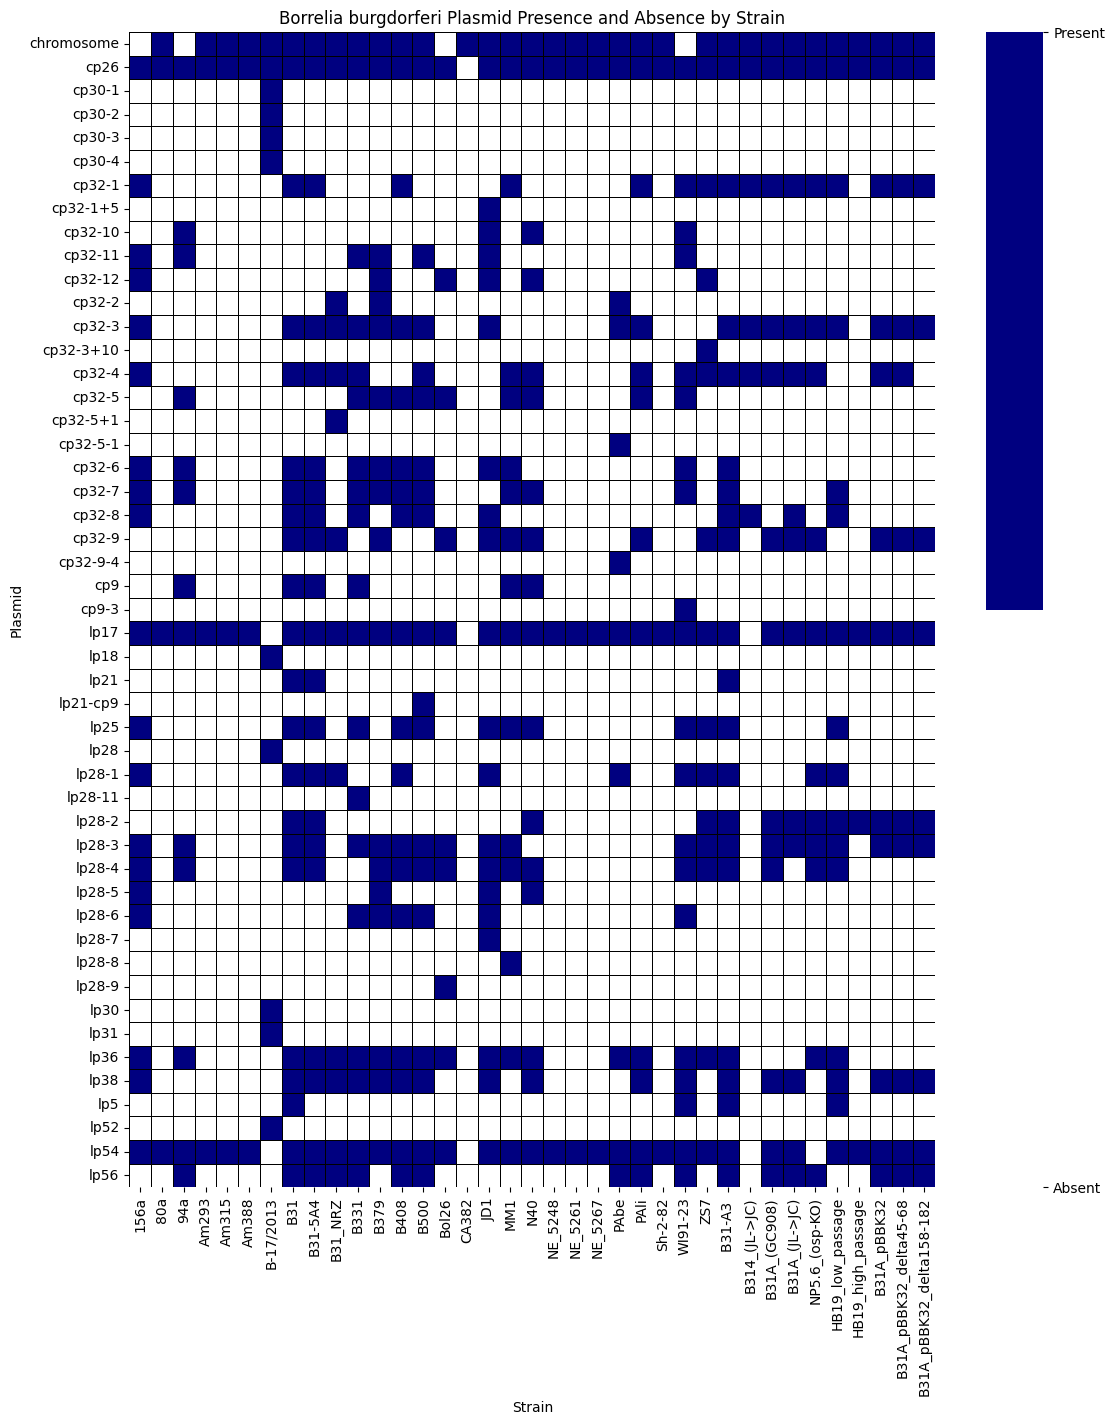

In [19]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

cmap = sns.color_palette("blend:White,Navy",2)
plt.figure(figsize=(13,15))
matrix = sns.heatmap(merged_table, linewidths=0.5, linecolor='black', cmap=cmap, xticklabels=True, yticklabels=True, )
colorbar = matrix.collections[0].colorbar
colorbar.set_ticks([0, 1])
colorbar.set_ticklabels(['Absent', 'Present',])

matrix.set_ylabel("Plasmid")
matrix.set_xlabel("Strain")
matrix.set_title("Borrelia burgdorferi Plasmid Presence and Absence by Strain")
plt.savefig("plasmid_heatmap.png", dpi=300,bbox_inches='tight')


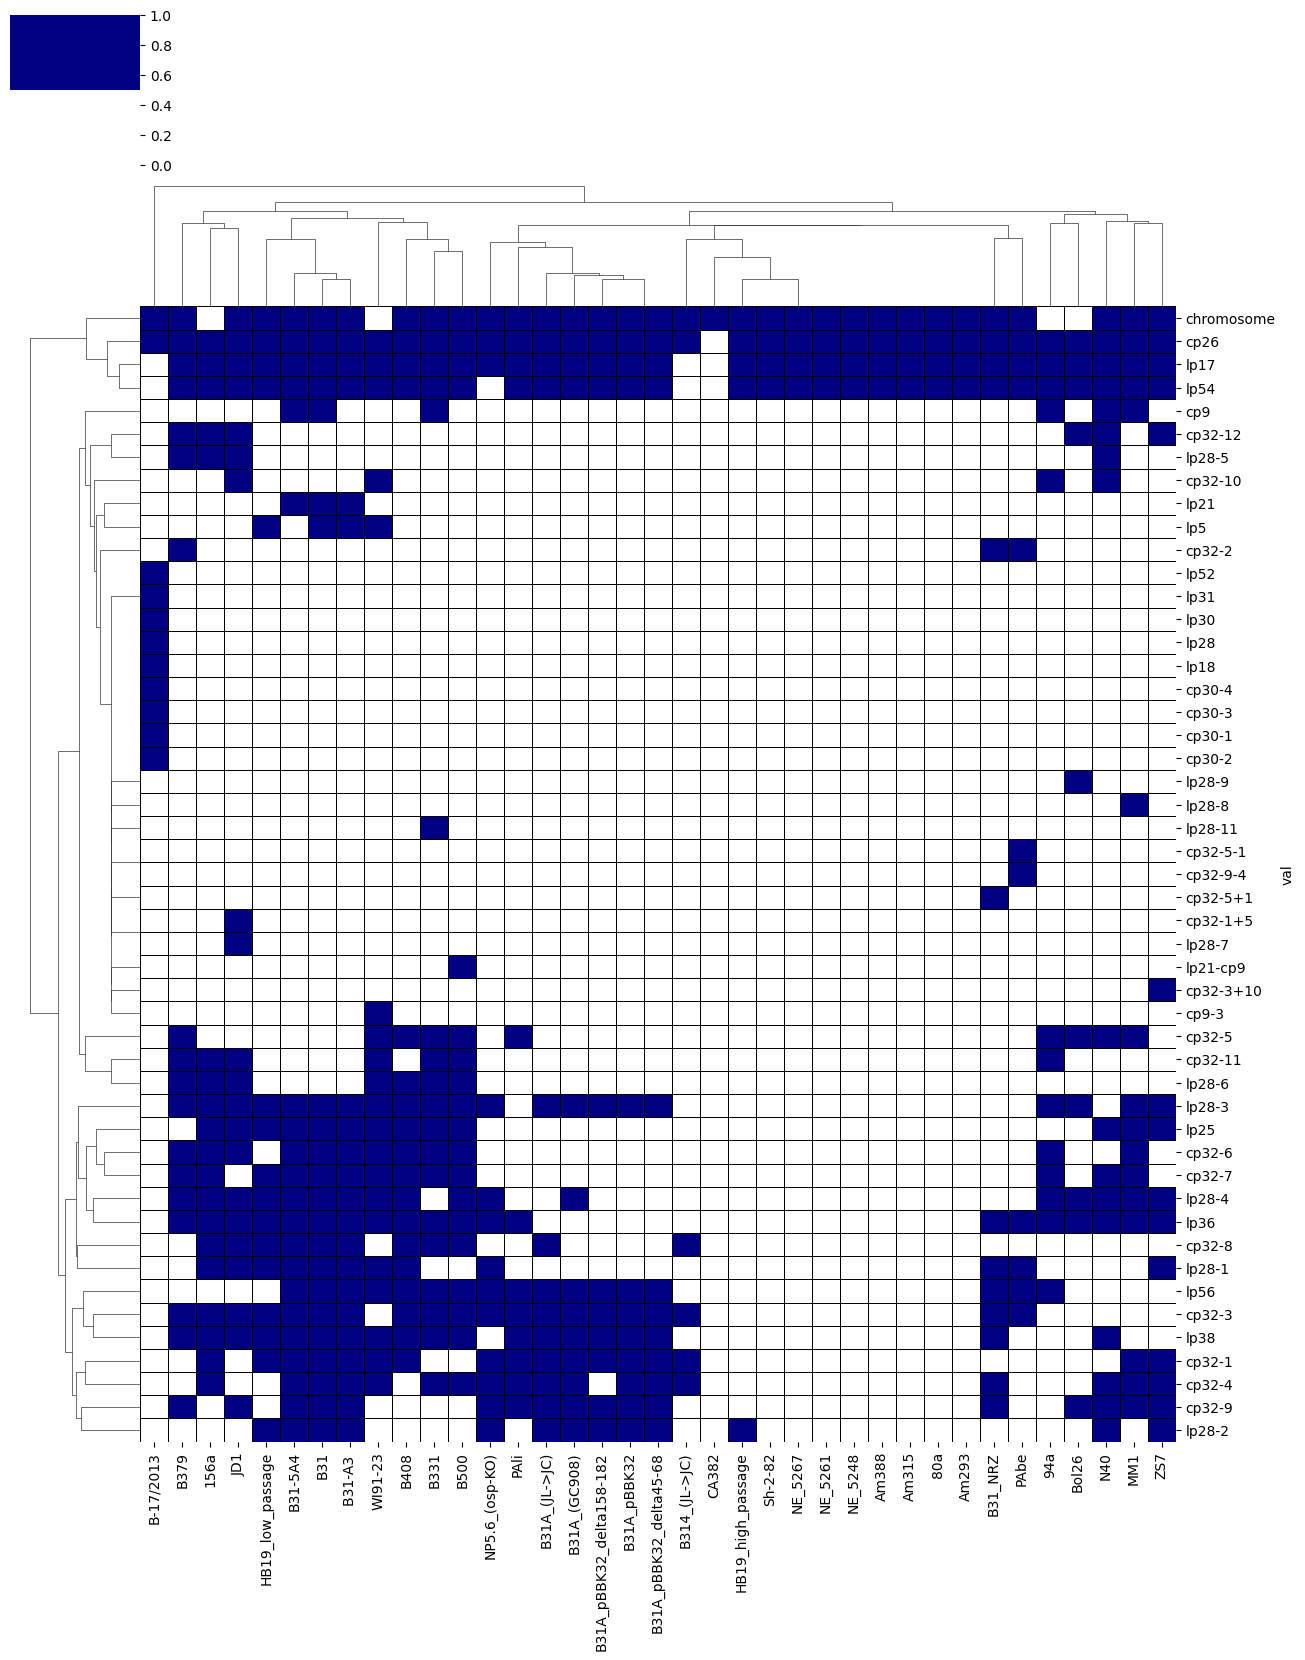

In [20]:
matrix = sns.clustermap(merged_table, figsize = (13,15), 
                        dendrogram_ratio = 0.1, metric='minkowski', 
                        cmap=cmap, linewidths=0.5, linecolor='black', 
                        cbar_pos=(0, 1,0.1,0.1))
colorbar.set_ticks([0, 1])
colorbar.set_ticklabels(['Absent', 'Present',])

plt.savefig("plasmid_heatmap_clustering.png", dpi=500, bbox_inches='tight')
